# GNN Final Project

## Import libraries

In [177]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report
from node2vec import Node2Vec
import os
import random
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T
from torch_geometric.transforms import Compose
from sklearn import metrics
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.semantic import TermCounts, semantic_similarity
import numpy as np
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from collections import defaultdict
from itertools import product


## Import data - DisGeNET disease associations and BioGRID network

- First, import DisGeNET data. For the logistic regression, genes associated with tuberculosis (TB) will be collected to be the positive labels. More genes will be propagated using these positive genes by using MONDO. Then random sampling will be done for the negative examples. Finally, logistic regression is trained on this set. This is the baseline model. 

- For the GAE and VGAE, the TB positive genes will also be collected and then used in the seed connector algorithm (SCA) to propagate more genes. This is the solution problem where we propagate more positive genes by using a different method instead of using the MONDO ontology structrue. Then the module and genes of this module will be verified by checking the module structure agains other randomly sampled modules created by the SCA using random proteins. The genes propagated by the SCA and the positive genes obtained from the DisGeNET will also under go a GO functional simalarity function to make sure the SCA genes are indeed likely candidates for postive TB examples. Then these propagated genesa are added to the DisGeNET set to be used for the GAE and VGAE models. 

### Get DisGeNET data

In [178]:
SEED = 42

# read in disgnet disease gene associations
disgenet_raw = pd.read_csv('../data/processed/not_propagated_disgenet_genes.tsv', delimiter= '\t')
disgenet_raw.head(15)

,gene_id,mondo_id,mondo_term
0,2,MONDO:0004975,Alzheimer disease
1,2,MONDO:0021063,malignant colon neoplasm
2,2,MONDO:0005401,colonic neoplasm
3,2,MONDO:0002050,depressive disorder
4,2,MONDO:0005376,membranous glomerulonephritis
5,2,MONDO:0010200,Wilson disease
6,2,MONDO:0005155,cirrhosis of liver
7,2,MONDO:0002691,liver cancer
8,2,MONDO:0005377,nephrotic syndrome
9,2,MONDO:0000940,trypanosomiasis


In [179]:
# get genes associated to TB
disgenet_tb_df = disgenet_raw[disgenet_raw['mondo_id'] == 'MONDO:0018076']
tb_pos_disgenes = [str(gene) for gene in set(disgenet_tb_df['gene_id'].tolist())]
disgenet_tb_df


,gene_id,mondo_id,mondo_term
34,10,MONDO:0018076,tuberculosis
664,100,MONDO:0018076,tuberculosis
1206,181,MONDO:0018076,tuberculosis
6472,820,MONDO:0018076,tuberculosis
6857,847,MONDO:0018076,tuberculosis
...,...,...,...
86443,343641,MONDO:0018076,tuberculosis
86489,345611,MONDO:0018076,tuberculosis
88782,646730,MONDO:0018076,tuberculosis
90210,101927980,MONDO:0018076,tuberculosis


In [180]:
print("Number of TB genes:", len(tb_pos_disgenes))

Number of TB genes: 93


### Load BioGRID and get connected network

In [181]:
# read in network data file
biogrid_raw = pd.read_csv("../data/bigdatasets/biogrid_network.txt", sep='\t') 

#take a look
biogrid_raw.head()


,#ID Interactor A,ID Interactor B,Alt IDs Interactor A,Alt IDs Interactor B,Aliases Interactor A,Aliases Interactor B,Interaction Detection Method,Publication 1st Author,Publication Identifiers,Taxid Interactor A,Taxid Interactor B,Interaction Types,Source Database,Interaction Identifiers,Confidence Values
0,entrez gene/locuslink:6416,entrez gene/locuslink:2318,biogrid:112315|entrez gene/locuslink:MAP2K4|un...,biogrid:108607|entrez gene/locuslink:FLNC|unip...,entrez gene/locuslink:JNKK(gene name synonym)|...,entrez gene/locuslink:ABP-280(gene name synony...,"psi-mi:""MI:0018""(two hybrid)",Marti A (1997),pubmed:9006895,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:103,-
1,entrez gene/locuslink:84665,entrez gene/locuslink:88,biogrid:124185|entrez gene/locuslink:MYPN|unip...,biogrid:106603|entrez gene/locuslink:ACTN2|uni...,entrez gene/locuslink:CMD1DD(gene name synonym...,entrez gene/locuslink:CMD1AA(gene name synonym),"psi-mi:""MI:0018""(two hybrid)",Bang ML (2001),pubmed:11309420,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:117,-
2,entrez gene/locuslink:90,entrez gene/locuslink:2339,biogrid:106605|entrez gene/locuslink:ACVR1|uni...,biogrid:108625|entrez gene/locuslink:FNTA|unip...,entrez gene/locuslink:ACTRI(gene name synonym)...,entrez gene/locuslink:FPTA(gene name synonym)|...,"psi-mi:""MI:0018""(two hybrid)",Wang T (1996),pubmed:8599089,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:183,-
3,entrez gene/locuslink:2624,entrez gene/locuslink:5371,biogrid:108894|entrez gene/locuslink:GATA2|uni...,biogrid:111384|entrez gene/locuslink:PML|unipr...,entrez gene/locuslink:DCML(gene name synonym)|...,entrez gene/locuslink:MYL(gene name synonym)|e...,"psi-mi:""MI:0018""(two hybrid)",Tsuzuki S (2000),pubmed:10938104,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:278,-
4,entrez gene/locuslink:6118,entrez gene/locuslink:6774,biogrid:112038|entrez gene/locuslink:RPA2|entr...,biogrid:112651|entrez gene/locuslink:STAT3|uni...,entrez gene/locuslink:REPA2(gene name synonym)...,entrez gene/locuslink:ADMIO(gene name synonym)...,"psi-mi:""MI:0018""(two hybrid)",Kim J (2000),pubmed:10875894,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:418,-


In [182]:
# biogrid has proteins for other species. I want only the human proteins so filter these out.
human_biogrid_raw =biogrid_raw[(biogrid_raw['Taxid Interactor A'] == "taxid:9606") & (biogrid_raw['Taxid Interactor B'] == "taxid:9606")]

In [183]:
# get rid of umwanted columns
columns_to_drop= ['Alt IDs Interactor A',
 'Alt IDs Interactor B',
 'Aliases Interactor A',
 'Aliases Interactor B',
 'Interaction Detection Method',
 'Publication 1st Author',
 'Publication Identifiers',
 'Taxid Interactor A',
 'Taxid Interactor B','Interaction Types',
 'Source Database',
 'Interaction Identifiers']
human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)

human_biogrid_raw.head()
print("Shape of dataframe", human_biogrid_raw.shape)

Shape of dataframe (1131384, 3)


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_68553/1794002502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)


In [184]:
# format values in the confidence values so only the numeric part is kept

#checking for na scores. NA scores are represented with '-'
look_at_score =human_biogrid_raw["Confidence Values"].unique()
# for score in look_at_score:
#     print(score)

#remove the score part
human_biogrid_raw.loc[:,'Confidence Values'] = human_biogrid_raw['Confidence Values'].str.replace('score:', '') 
    
print(human_biogrid_raw.dtypes)
#get rid of any rows that have '-' in the confidence value
filtered_biogrid = human_biogrid_raw[human_biogrid_raw['Confidence Values'] != "-"]

# ensure correct data type for the confidence scores.
filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)
print("After changing dat types \n", filtered_biogrid.dtypes)

# now doing the same for the genes in interactor a and b columns
filtered_biogrid.loc[:, '#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].str.split(':').str[-1]

filtered_biogrid.loc[:, 'ID Interactor B'] = filtered_biogrid['ID Interactor B'].str.split(':').str[-1]

# check data type of columns
print("Check data type\n", filtered_biogrid.dtypes)

#ID Interactor A     object
ID Interactor B      object
Confidence Values    object
dtype: object
After changing dat types 
 #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_68553/1519717752.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)


Check data type
 #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


In [185]:
# check data frame
filtered_biogrid.head()

,#ID Interactor A,ID Interactor B,Confidence Values
121446,10421,23020,1.000
121447,10755,4646,0.952
121448,1974,1981,0.931
121449,10421,10594,0.919
121450,382,10128,0.909


In [186]:
# check range of confidence values
max_conf_values = filtered_biogrid['Confidence Values'].max()
min_conf_values = filtered_biogrid['Confidence Values'].min()

print(f"Max confidence value { max_conf_values} and min confidence value {min_conf_values}")

Max confidence value 52530.0 and min confidence value -24.621


In [187]:
# Scale confidence values to improve model performance

scale = StandardScaler()
filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))
# drop confidence values column and only keep the standardized values
filtered_biogrid.drop(columns='Confidence Values', inplace=True)

filtered_biogrid.head(20)

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_68553/4269995461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))
/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_68553/4269995461.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid.drop(columns='Confidence Values', inplace=True)


,#ID Interactor A,ID Interactor B,Standardized_confidence_values
121446,10421,23020,-0.070923
121447,10755,4646,-0.071073
121448,1974,1981,-0.071139
121449,10421,10594,-0.071177
121450,382,10128,-0.071208
121451,7532,3799,-0.071236
121452,9337,23019,-0.071239
121453,55723,79711,-0.071568
121454,28988,8924,-0.071603
121455,9410,10594,-0.071612


In [188]:
# need to get the adjecancy matrix of the biogrid data frame

# first check to see if the edge list results in a connected graph
graph = nx.from_pandas_edgelist(filtered_biogrid, '#ID Interactor A', 'ID Interactor B')
is_connected = nx.is_connected(graph)
print(is_connected)
# output whether the graph is connected or not
if is_connected:
    print("The Human BioGRID network is fully connected.")
else:
    print("The Human BioGRID network is not fully connected.")

# find the connected components
connected_components = list(nx.connected_components(graph))

# get the largest connected component
largest_component = max(connected_components, key=len)
print(f"Largest component size: {len(largest_component)}.")

# keep only interactions within the largest connected component
only_connected_biogrid = filtered_biogrid[
    (filtered_biogrid['#ID Interactor A'].isin(largest_component)) &
    (filtered_biogrid['ID Interactor B'].isin(largest_component))
]

# start building the adjacency matrix
num_genes = len(largest_component)
adj_matrix = np.zeros((num_genes, num_genes))

# create a mapping of genes to indices
gene_to_index = {gene: i for i, gene in enumerate(largest_component)}

# iterate through the df to fill the adjacency matrix
for _, row in only_connected_biogrid.iterrows():
    gene_a_index = gene_to_index.get(row['#ID Interactor A'])
    gene_b_index = gene_to_index.get(row['ID Interactor B'])
    confidence_value = row['Standardized_confidence_values']
    if not np.isnan(confidence_value):
        adj_matrix[gene_a_index, gene_b_index] = confidence_value
        adj_matrix[gene_b_index, gene_a_index] = confidence_value  

# check for rows in the adjacency matrix that have all zeros
rows_with_all_zeros = np.where(~adj_matrix.any(axis=1))[0]

if len(rows_with_all_zeros) > 0:
    print("Rows with all zeros found at indices:", rows_with_all_zeros)
else:
    print("No rows with all zeros found.")
    
connected_biogrid_graph = nx.from_pandas_edgelist(only_connected_biogrid, '#ID Interactor A', 'ID Interactor B')
is_connected = nx.is_connected(connected_biogrid_graph)
print(is_connected)
# output whether the graph is connected or not
if is_connected:
    print("The Human BioGRID network is fully connected.")
else:
    print("The Human BioGRID network is not fully connected.")


False
The Human BioGRID network is not fully connected.
Largest component size: 15800.
No rows with all zeros found.
True
The Human BioGRID network is fully connected.


### Prep data for the Logistic Regression Model

##### Get positive and negative examples. Then create the feature matrix and target vector

In [189]:
# read in disgnet disease gene associations, this is base don using the mondo ontology to propagate
disgenet_propagated = pd.read_csv('../data/processed/tb_propagated_disgenet_genes.tsv', delimiter= '\t')
propagated_tb_genes = [str(gene) for gene in set(disgenet_propagated['gene_id'].tolist())]
print(len(propagated_tb_genes))

106


In [190]:
# function that will check to see if the positive genes are in the network. 
# If they are not in the network then they are taken out. Keep track of which genes are removed

def genes_in_network(positive_list, genes_to_index, adjacency_matrix):
    # get the set of genes that are in the new adjacency matrix
    genes_in_network_set = set(genes_to_index.keys())

    removed_genes = []
    
    # keep genes in the positive list if they are found in the network
    filtered_positive_list = []
    for gene in positive_list:
        if gene in genes_in_network_set:
            filtered_positive_list.append(gene)
        else:
            removed_genes.append(gene)
        
     # get the indexes of the the negative genes to get them from the adj matrix
    positive_indices = [genes_to_index[gene] for gene in filtered_positive_list]
    
    # get the negative gene subset from the adjacency matrix 
    positive_adjacency_matrix = adjacency_matrix[positive_indices, :]
    
    # make new gene to index dictionary containing only the negative genes
    positive_gene_to_index = {gene: genes_to_index[gene] for gene in positive_list if gene in genes_to_index}

    # since shape of adj matrix changed, have to start new indexes
    new_positive_indices = list(range(positive_adjacency_matrix.shape[0]))

    # make new gene to index dictionary containing only the negative genes
    new_positive_gene_to_index = {gene: index for index, gene in enumerate(filtered_positive_list)}

    return filtered_positive_list, removed_genes, positive_adjacency_matrix, positive_gene_to_index, new_positive_gene_to_index


In [191]:
tb_pos, removed_disgenet_genes, tb_pos_disgenet_features, disgenet_posgen2ind, new_disgenet_posgen2ind = genes_in_network(propagated_tb_genes, gene_to_index, adj_matrix)
# get some quick counts on genes in and out of network

print(f"Positive genes in network for DisGeNET: {len(tb_pos)}")

print(f"Genes not in network for DisGeNET set: {len(removed_disgenet_genes)}")

print(f"Positve gene tb disgenet list {tb_pos}")
print(f"new pos disgenet gene2indices {new_disgenet_posgen2ind}")
print(f"Positve gene tb disgenet list length {len(tb_pos)}")
print(f"new pos disgenet gene2indices length {len(new_disgenet_posgen2ind)}")

Positive genes in network for DisGeNET: 86
Genes not in network for DisGeNET set: 20
Positve gene tb disgenet list ['3586', '10', '3594', '345611', '1555', '3605', '3606', '27161', '23583', '3105', '1571', '3623', '3627', '3119', '3123', '3125', '3127', '4153', '5199', '7248', '7249', '6737', '51284', '30813', '100', '27241', '54892', '30835', '6774', '50807', '64127', '8838', '2213', '3240', '3242', '181', '59067', '9927', '6347', '717', '6352', '4312', '4318', '4843', '54509', '1786', '7421', '50943', '3329', '10529', '129831', '79659', '820', '9021', '80196', '3918', '847', '54106', '9564', '1380', '3431', '25966', '3439', '6002', '3447', '1401', '7040', '3458', '3459', '11151', '1437', '929', '5034', '114609', '7096', '7097', '27074', '4045', '1999', '7124', '3552', '3558', '8170', '3569', '7153', '3576']
new pos disgenet gene2indices {'3586': 0, '10': 1, '3594': 2, '345611': 3, '1555': 4, '3605': 5, '3606': 6, '27161': 7, '23583': 8, '3105': 9, '1571': 10, '3623': 11, '3627': 12, 

In [192]:
# check to see if gene sin negative set are in the new genest_to_index for the negative set
key_to_check = '27161'
if key_to_check in new_disgenet_posgen2ind:
    print("Value for key '{}': {}".format(key_to_check, new_disgenet_posgen2ind[key_to_check]))
else:
    print("Key '{}' is not present in the dictionary.".format(key_to_check))
    if key_to_check in removed_disgenet_genes:
        print("Value {} found in the removed list. This gene was not part of the network.".format(key_to_check))
    else:
        print("Value {} not found in the removed list.".format(key_to_check))

Value for key '27161': 7


In [193]:
def load_negatives(positive_list, genes_to_index, adjacency_matrix, tsv_file):
    
    #load tsv file containing negative examples
    negative_genes_df = pd.read_csv(tsv_file, sep='\t')
    negative_list = negative_genes_df['Negative Genes'].tolist()
    negative_list = [str(gene) for gene in negative_list]

    #get indexes
    negative_indices = [genes_to_index[gene] for gene in negative_list]
    
    # get the negative gene subset from the adjacency matrix 
    negative_adjacency_matrix = adjacency_matrix[negative_indices, :]

    # create a new gene-to-index dictionary containing only the negative genes
    negative_gene_to_index = {gene: genes_to_index[gene] for gene in negative_list if gene in genes_to_index}

    # since the shape of the adjacency matrix changed, start new indexes
    new_negative_indices = list(range(negative_adjacency_matrix.shape[0]))

    # create a new gene-to-index dictionary containing only the negative genes
    new_negative_gene_to_index = {gene: index for index, gene in enumerate(negative_list)}

    return negative_list, negative_adjacency_matrix, negative_gene_to_index, new_negative_gene_to_index



In [194]:
# get negative list
tb_neg, tb_disgenet_neg_feat, old_disgenet_negind, disgenet_neg_gene2ind = load_negatives(tb_pos, gene_to_index, adj_matrix, '../data/processed/tb_negative_genes.tsv')

# get quick count to make sure the negatives match the number of positives
print(f"Negative genes in network for DisGeNET: {len(tb_neg)} {tb_neg}")
print(f"adj_matrix for disgenet negatives shape and view: {tb_disgenet_neg_feat.shape} \n{tb_disgenet_neg_feat}")
print(disgenet_neg_gene2ind)

Negative genes in network for DisGeNET: 86 ['83853', '210', '11157', '91373', '11041', '90135', '6903', '148268', '84337', '516', '27333', '117145', '148156', '1455', '3815', '26223', '116154', '63970', '55066', '10579', '22913', '381', '222962', '23205', '1652', '5464', '6700', '22994', '9136', '4909', '6504', '64066', '284359', '340547', '813', '9446', '1912', '9252', '155370', '2259', '10174', '51649', '80235', '54935', '23389', '5192', '11213', '55030', '7574', '23294', '376132', '10277', '170850', '5164', '286205', '5777', '55599', '3099', '114327', '55671', '998', '27123', '3275', '654429', '26520', '91608', '1616', '389123', '6834', '401152', '9181', '672', '57560', '284106', '5355', '286016', '23677', '51059', '8886', '1641', '1665', '55859', '55222', '79722', '7434', '51186']
adj_matrix for disgenet negatives shape and view: (86, 15800) 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. 

In [195]:
# check to see if gene sin negative set are in the new genest_to_index for the negative set
key_to_check = tb_neg[26]
if key_to_check in disgenet_neg_gene2ind:
    print("Value for key '{}': {}".format(key_to_check, disgenet_neg_gene2ind[key_to_check]))
else:
    print("Key '{}' is not present in the dictionary.".format(key_to_check))

Value for key '6700': 26


In [196]:
# check to see if the list share any genes
intersection = np.intersect1d(tb_neg, tb_pos)

if len(intersection) == 0:
    print("tb_neg and tb_pos do not share any values.")
else:
    print("tb_neg and tb_pos share values.")
    
print("Number of positive genes:", len(tb_pos))
print("Number of negative genes:", len(tb_neg))

tb_neg and tb_pos do not share any values.
Number of positive genes: 86
Number of negative genes: 86


In [197]:
def get_feat_matrix(pos_adj_mat, neg_adj_mat, pos_gene2ind, neg_gene2ind):
    # assign labels to positive genes = 1
    pos_gene2ind_labeled = {gene: [index, 1] for gene, index in pos_gene2ind.items()}
    
    # assign labels to negative genes = 0
    neg_gene2ind_labeled = {gene: [index, 0] for gene, index in neg_gene2ind.items()}
    
    # determine the starting index for the second gene-to-index dictionary
    start_index = len(pos_gene2ind)
    print("start index:", start_index)
    print("pos_gene2ind:", pos_gene2ind_labeled)
    
    # update the index values in the second gene-to-index dictionary
    for gene, index in neg_gene2ind_labeled.items():
        index[0] += start_index  # Increment the index for negative genes
    
    print("neg_gene2ind with labels:", neg_gene2ind_labeled)
    
    # combine the two dictionaries
    combined_gene2index = {**pos_gene2ind_labeled, **neg_gene2ind_labeled}
    print("Combined gene-to-index dictionary:", combined_gene2index)
    
    # concatenate the two adjacency matrices
    combined_adj_mat = np.concatenate((pos_adj_mat, neg_adj_mat), axis=0)
    print("Combined adjacency matrix shape:", combined_adj_mat.shape)


    return combined_adj_mat, combined_gene2index



disgenet_feature_mat, disgenet_feature_gene2ind = get_feat_matrix(tb_pos_disgenet_features, tb_disgenet_neg_feat, new_disgenet_posgen2ind, disgenet_neg_gene2ind )


start index: 86
pos_gene2ind: {'3586': [0, 1], '10': [1, 1], '3594': [2, 1], '345611': [3, 1], '1555': [4, 1], '3605': [5, 1], '3606': [6, 1], '27161': [7, 1], '23583': [8, 1], '3105': [9, 1], '1571': [10, 1], '3623': [11, 1], '3627': [12, 1], '3119': [13, 1], '3123': [14, 1], '3125': [15, 1], '3127': [16, 1], '4153': [17, 1], '5199': [18, 1], '7248': [19, 1], '7249': [20, 1], '6737': [21, 1], '51284': [22, 1], '30813': [23, 1], '100': [24, 1], '27241': [25, 1], '54892': [26, 1], '30835': [27, 1], '6774': [28, 1], '50807': [29, 1], '64127': [30, 1], '8838': [31, 1], '2213': [32, 1], '3240': [33, 1], '3242': [34, 1], '181': [35, 1], '59067': [36, 1], '9927': [37, 1], '6347': [38, 1], '717': [39, 1], '6352': [40, 1], '4312': [41, 1], '4318': [42, 1], '4843': [43, 1], '54509': [44, 1], '1786': [45, 1], '7421': [46, 1], '50943': [47, 1], '3329': [48, 1], '10529': [49, 1], '129831': [50, 1], '79659': [51, 1], '820': [52, 1], '9021': [53, 1], '80196': [54, 1], '3918': [55, 1], '847': [56, 1]

In [198]:
# make target vector
def get_target_vector(combined_gene2in, feature_mat):
    # initialize target vector 
    target_vector = np.zeros(len(feature_mat), dtype= int)
    index = 0

    # map gene IDs to indices and label positive samples
    for index, genes in enumerate(combined_gene2in.keys()):
        class_label = combined_gene2in.get(genes)[1]
        target_vector[index] = class_label
         
    return(target_vector)

In [199]:
disgenet_target_vector = get_target_vector(disgenet_feature_gene2ind, disgenet_feature_mat)
print("disgenet target vector and shape :{} {} ".format(disgenet_target_vector, disgenet_target_vector.shape))
print("disgenet feature matrix ", disgenet_feature_mat.shape)

disgenet target vector and shape :[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (172,) 
disgenet feature matrix  (172, 15800)


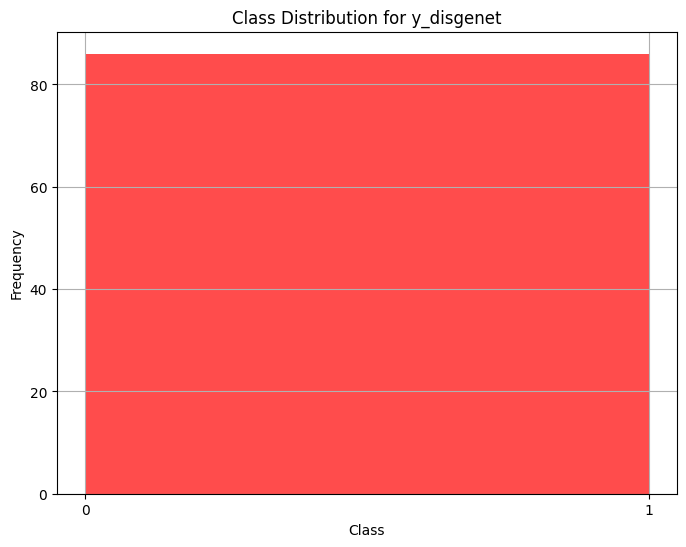

In [200]:
# plot class distribution
plt.figure(figsize=(8, 6))
plt.hist(disgenet_target_vector, bins=2, color='red', alpha=0.7)
plt.title('Class Distribution for y_disgenet')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1]) 
plt.grid(True)
plt.show()

In [201]:
# function to get unlabeled data
def unlabeled_data(adj_matrix, adj_gene_to_index, feature_gene_to_index):

    # Get the keys (genes) from feature_gene_to_index
    genes_to_remove = feature_gene_to_index.keys()

    # Get the indices of genes to remove from adj_gene_to_index
    indices_to_remove = [adj_gene_to_index[gene] for gene in genes_to_remove if gene in adj_gene_to_index]

    # Remove rows and columns from the adjacency matrix
    adj_matrix = np.delete(adj_matrix, indices_to_remove, axis=0)
    return adj_matrix

In [202]:
unlabeled_data = unlabeled_data(adj_matrix, gene_to_index, disgenet_feature_gene2ind)
print(unlabeled_data.shape)

(15628, 15800)


#### Embed the feature matrix

In [203]:
# get embeddings

#create embeddings for adj matrix
def get_embeddings(matrix, seed = SEED):
    # initialize graph for adj matrix
    graph = nx.Graph()

    # add edges from the adjacency matrix to the graph
    num_nodes = matrix.shape[0]
    print("Number of nodes in the graph:", num_nodes)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):  # upper triangle to avoid duplicate edges
            if matrix[i, j] != 0:  # include only all non-zero values
                graph.add_edge(i, j, weight=matrix[i, j])

    print(f"num_nodes value: {num_nodes}")
    print(f"graph_features value:  {graph.number_of_nodes()}")

    # Check for isolated nodes (nodes without edges)
    for node in range(num_nodes):
        if node not in graph:
            graph.add_node(node)

    print(f"Graph nodes after adding isolated nodes: {graph.number_of_nodes()}")

    # generate embeddings
    node2vec = Node2Vec(graph, dimensions=100, walk_length=90, num_walks=25, p=8, q=1, seed=SEED, workers=1)
    model_features = node2vec.fit(window=10)

    # Ensure all nodes are included in embeddings
    embeddings = np.array([model_features.wv[str(node)] if str(node) in model_features.wv else np.zeros(128) for node in range(num_nodes)])

    print(f"Shape of feature_embeddings: {embeddings.shape}")
    
    return embeddings
disgenet_feature_embeddings = get_embeddings(disgenet_feature_mat, SEED)


Number of nodes in the graph: 172
num_nodes value: 172
graph_features value:  39
Graph nodes after adding isolated nodes: 172


Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 114.54it/s]


Shape of feature_embeddings: (172, 100)


#### Train and test split

In [204]:
# declare test and train sets
print(disgenet_feature_embeddings.shape)
X_disgenet = disgenet_feature_embeddings
y_disgenet = disgenet_target_vector
print("Shape of target vector: ", y_disgenet.shape)
print("Shape of feature matrix: ", X_disgenet.shape)
print("Number of samples in y_disgenet:", y_disgenet.shape[0])

X_train_disgenet, X_test_disgenet, y_train_disgenet, y_test_disgenet = train_test_split(X_disgenet, y_disgenet, test_size= 0.2, random_state=42, shuffle=True, stratify=y_disgenet)


(172, 100)
Shape of target vector:  (172,)
Shape of feature matrix:  (172, 100)
Number of samples in y_disgenet: 172


#### Define logistic regression model, train, test, and tune

In [205]:
lr = LogisticRegression(max_iter= 8000, random_state=42, multi_class= 'ovr')

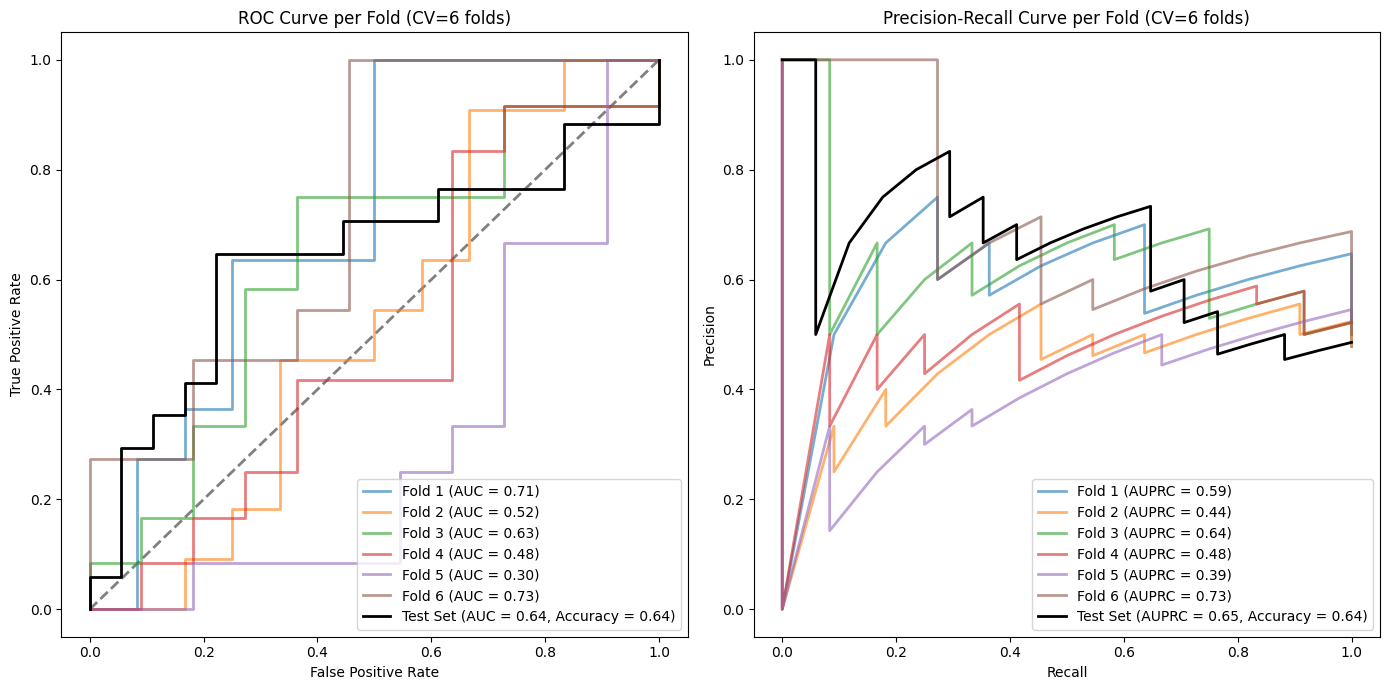

{'accuracy': 0.569828722002635, 'f1_score': 0.6710307406034138, 'balanced_accuracy': 0.5688131313131314, 'precision': 0.5423210804789752, 'recall': 0.8876262626262625, 'roc_auc': 0.5606060606060606, 'pr_auc': 0.6686770450673754, 'tn': 2.8333333333333335, 'fp': 8.5, 'fn': 1.3333333333333333, 'tp': 10.166666666666666, 'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      0.17      0.29        12\n           1       0.52      1.00      0.69        11\n\n    accuracy                           0.57        23\n   macro avg       0.76      0.58      0.49        23\nweighted avg       0.77      0.57      0.48        23\n'}


In [206]:
fold_num=6
cv = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=42)
metrics_list = []

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.title(f'ROC Curve per Fold (CV={fold_num} folds)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)

plt.subplot(1, 2, 2)
plt.title(f'Precision-Recall Curve per Fold (CV={fold_num} folds)')
plt.xlabel('Recall')
plt.ylabel('Precision')

for i, (train, test) in enumerate(cv.split(X_train_disgenet, y_train_disgenet)):
    lr.fit(X_train_disgenet[train], y_train_disgenet[train])
    y_pred_test = lr.predict(X_train_disgenet[test])
    y_pred_prob = lr.predict_proba(X_train_disgenet[test])[:, 1]

    # get performance metrics
    accuracy = accuracy_score(y_train_disgenet[test], y_pred_test)
    f1 = f1_score(y_train_disgenet[test], y_pred_test)
    balanced_acc = balanced_accuracy_score(y_train_disgenet[test], y_pred_test)
    precision = precision_score(y_train_disgenet[test], y_pred_test)
    recall = recall_score(y_train_disgenet[test], y_pred_test)
    roc_auc = roc_auc_score(y_train_disgenet[test], y_pred_prob)
    report = classification_report(y_train_disgenet[test], y_pred_test)
    tn, fp, fn, tp = confusion_matrix(y_train_disgenet[test], y_pred_test).ravel()

    metrics_list.append({
        "accuracy": accuracy,
        "f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "report": report,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    })

    # compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_train_disgenet[test], y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # plot ROC curve for this fold
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, lw=2, alpha=0.6, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

    # compute Precision-Recall curve and AUPRC
    precision_curve, recall_curve, _ = precision_recall_curve(y_train_disgenet[test], y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)

    # plot Precision-Recall curve for this fold
    plt.subplot(1, 2, 2)
    plt.plot(recall_curve, precision_curve, lw=2, alpha=0.6, label=f'Fold {i+1} (AUPRC = {pr_auc:.2f})')

# plot the ROC and Precision-Recall curves for the test set
lr.fit(X_train_disgenet, y_train_disgenet)
y_pred_test = lr.predict(X_test_disgenet)
y_pred_prob = lr.predict_proba(X_test_disgenet)[:, 1]

# compute ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_test_disgenet, y_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# compute rrecision-recall curve and AUPRC for the test set
precision_test, recall_test, _ = precision_recall_curve(y_test_disgenet, y_pred_prob)
pr_auc_test = auc(recall_test, precision_test)

# Plot ROC curve for the test set
plt.subplot(1, 2, 1)
plt.plot(fpr_test, tpr_test, lw=2, color='black', label=f'Test Set (AUC = {roc_auc_test:.2f}, Accuracy = {accuracy:.2f})')

# plot precision-recall curve for the test set
plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, lw=2, color='black', label=f'Test Set (AUPRC = {pr_auc_test:.2f}, Accuracy = {accuracy:.2f})')

# define legend
plt.subplot(1, 2, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../data/figures/logisticreg_best_cv_roc_auc_curves.png', dpi=600)
plt.show()

# calculate overall metrics
overall_metrics = {
    "accuracy": np.mean([m["accuracy"] for m in metrics_list]),
    "f1_score": np.mean([m["f1_score"] for m in metrics_list]),
    "balanced_accuracy": np.mean([m["balanced_accuracy"] for m in metrics_list]),
    "precision": np.mean([m["precision"] for m in metrics_list]),
    "recall": np.mean([m["recall"] for m in metrics_list]),
    "roc_auc": np.mean([m["roc_auc"] for m in metrics_list]),
    "pr_auc": np.mean([auc(precision_recall_curve(y_train_disgenet[test], lr.predict_proba(X_train_disgenet[test])[:, 1])[1], precision_recall_curve(y_train_disgenet[test], lr.predict_proba(X_train_disgenet[test])[:, 1])[0]) for train, test in cv.split(X_train_disgenet, y_train_disgenet)]),
    "tn": np.mean([m["tn"] for m in metrics_list]),
    "fp": np.mean([m["fp"] for m in metrics_list]),
    "fn": np.mean([m["fn"] for m in metrics_list]),
    "tp": np.mean([m["tp"] for m in metrics_list]),
    "classification_report": metrics_list[0]["report"]  #
}

print(overall_metrics)



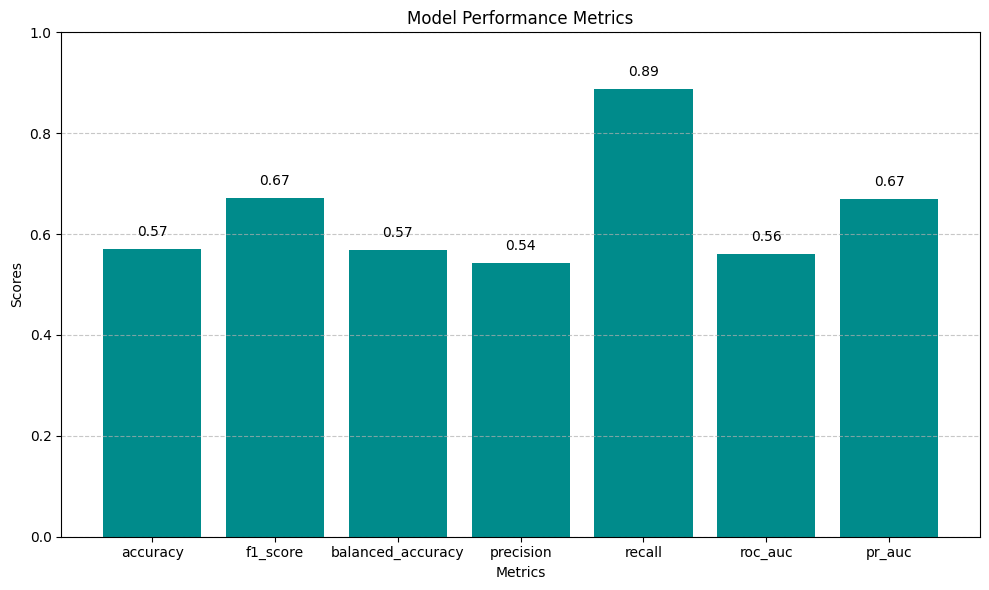

In [207]:
metrics_names = ["accuracy", "f1_score", "balanced_accuracy", "precision", "recall", "roc_auc", "pr_auc"]
metrics_values = [overall_metrics[name] for name in metrics_names]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics_values, color='darkcyan')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)  # Assuming all metrics are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the score values on top of the bars
for i, value in enumerate(metrics_values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../data/figures/logisticreg_performance_metrics.png', dpi=600)
plt.show()

## Propagate more genes using Seed Connecting Algorithm
## Build and Implement GAE and VGAE 

#### Seed connector algorithm 
 [Algorithm adapted from Kumar et. al (2020)](https://elifesciences.org/articles/54082/figures#fig5s4)<br>
 [GitHub URL to seed connector code](https://github.com/extavourlab/hpo_ova_eggL_screen/blob/master/Notebooks/04_Seed-Connector.ipynb)

In [208]:
class SeedConnector:
    def __init__(self, G, seed_set):
        # initialize PPI and seed list
        self.G = G
        self.seeds = seed_set
        
    def getLCC (self, subG):
        # Get the largest connecting component subnetwork from the entire netowork
        largest_connection_comp = max(nx.connected_components(subG), key =len)
        return largest_connection_comp
    
    def getSubG(self, nodes):
        # get the subggraph induced by seed genes and connectors once algorithm starts
        subG = self.G.subgraph(nodes)
        return subG
    
    def getNeighbors(self, subG):
        # get first order neighbors of the nodes
        # data structure to hold the list of neighbors
        neighbors = []
        
        # iterate through all the nodes of subG
        for node in subG.nodes():
            # list all connected neigh to the node you are looking at
            neigh = list(self.G[node].keys())
            # add nieghbor if ot in list already
            neighbors += [n for n in neigh if n not in neighbors]
        # take out any repeated neighbor nodes from subG.nodes()
        neighbors = [n for n in neighbors if n not in subG.nodes()]
        return neighbors
    
    def run_algo(self):
        # run the seed connector algorithm
        t0 = time.time()
        #get the seed subgraph
        subG = self.getSubG(self.seeds)
        # get the initial seed subgraph
        initLCC = self.getLCC(subG)
        # keep track of the initial size of the LCC
        initCoverage = len(initLCC)
        # initialize a new coverage that will get updated each iteration until new LLC size is found
        newCoverage = 0
        # initialize the current module as the seeds
        module = [i for i in self.seeds]
        # use dictionary to keep track of data
        progress = {'Coverage':[], 'LCC':[], 'Size':[], 'Step':{}, 'Path':[]}
        # start counter
        c = 0
        # message to indicate some stats
        print('Starting with ', len(self.seeds), "seeds")
        print("{} are in the PPI".format(len(subG)))
        print("{} are missing".format([s for s in self.seeds if s not in subG]))
        # continue the algorithm if adding nodes to the module increases coverage
        # Iteration step
        while newCoverage != initCoverage:
            # if the coverage is over the number of seeds the module has expanded so stop
            if newCoverage > len(self.seeds):
                break
            # update the initCoverage count to the new coverage to keep track of the changes for each iteration
            initCoverage = newCoverage
            # create result list
            result = []
            # get subgraph of the current module
            subG = self.getSubG(module)
            # get all the connected neighbors
            neighbors = self.getNeighbors(subG)
            # now go through all the neighbors and calculate the data results (coverage, lcc, and size)
            for vecino in neighbors:
                # get new module
                newmodule = module + [vecino]
                # get the subgraph of the new module
                newsubG = self.getSubG(newmodule)
                #get the largest component of the new module
                neigLCC = self.getLCC(newsubG)
                #initialize coverage
                coverage = 0
                #go through all the seed genes
                for gene in self.seeds:
                    # if the seed gene is in the new LCC
                    if gene in neigLCC:
                        # increase the coverage by 1
                        coverage += 1
                # save results
                result.append((vecino, coverage, len(neigLCC)))
            # sort results
            result = sorted(result, reverse = True, key = lambda x: x[0])
            # get the best coverage
            best_coverage = max(result, key = lambda x: x[1])[1]
            # set seed
            np.random.seed(42)
            # take random gene from the best genes list if therea are multiple best gene candidates
            best_gene = np.random.choice([gene[0] for gene in result if gene[1] == best_coverage])
            # pick best coverage which is the one with the max coverage
            newCoverage = best_coverage
            # save the LCC size
            LCC= [gene[2] for gene in result if gene [0] == best_gene][0]
            #add new gene to module
            module.append(best_gene)
            # log all the values into logging progress
            print("New coverage:", newCoverage, "Old Coverage:", initCoverage, "Module Size:", len(module), "LCC:", LCC)
            progress['Coverage'].append(newCoverage)
            progress['LCC'].append(LCC)
            progress['Size'].append(len(module))
            progress['Step'][c] = module
            progress['Path'].append(best_gene)
            # increase counter
            c+=1
        # the very last step does not increase the coverage so the last element has to be removed
        module.pop()
        total_time = (time.time() - t0)/60
        print("Execution time: ",round(total_time,2), "minutes.")
        return module, progress

#### Build modules using the algorithm
[As per hpo_ova_eggL_screen github](https://github.com/extavourlab/hpo_ova_eggL_screen/blob/master/Notebooks/04_Seed-Connector.ipynb)

In [209]:
def build_module(seed_genes, G):
    #build module using the seed list
    # initialize algorithm with PPI 
    S = SeedConnector(G, seed_genes)
    # run algorithm
    module, progress = S.run_algo()
    #plot the progress to track progress and to detect problems    
    plt.plot(np.array(progress['LCC'])/np.array(progress['Size']))
    plt.xlabel("Algorithm steps")
    plt.ylabel("LCC/NetworkSize")
    return module
    
def label_module(seed, module, G):
    # create the module by taking its subnetwork from the PPI
    subG = G.subgraph(module).copy()
    
    # iterate through all the nodes
    for node in subG.nodes():
        # if the node is in the seeds, label it as seed
        if node in seed:
            subG.nodes[node]['Seed'] = "Seed"
        # if the node is not in the seeds but is connected to seed genes, label it as connector
        elif any(subG.has_edge(seed_node, node) for seed_node in seed):
            subG.nodes[node]['Seed'] = "Connector"
        # otherwise, it is a newly propagated gene, decorate it as positive
        else:
            subG.nodes[node]['Seed'] = "Positive"
    return subG

In [210]:
# call functions to start SCA 
get_module = build_module(tb_pos_disgenes, connected_biogrid_graph)

# label the module
final_network = label_module(tb_pos_disgenes, get_module, connected_biogrid_graph)

Starting with  93 seeds
75 are in the PPI
['3593', '101927980', '2096', '646730', '343641', '80712', '9048', '57232', '4498', '6556', '5027', '50616', '7099', '50639', '3553', '105374693', '3560', '3565'] are missing
New coverage: 15 Old Coverage: 0 Module Size: 94 LCC: 16
New coverage: 19 Old Coverage: 15 Module Size: 95 LCC: 21
New coverage: 23 Old Coverage: 19 Module Size: 96 LCC: 26
New coverage: 27 Old Coverage: 23 Module Size: 97 LCC: 31
New coverage: 31 Old Coverage: 27 Module Size: 98 LCC: 36
New coverage: 35 Old Coverage: 31 Module Size: 99 LCC: 41
New coverage: 38 Old Coverage: 35 Module Size: 100 LCC: 45
New coverage: 40 Old Coverage: 38 Module Size: 101 LCC: 48
New coverage: 42 Old Coverage: 40 Module Size: 102 LCC: 51
New coverage: 44 Old Coverage: 42 Module Size: 103 LCC: 54
New coverage: 46 Old Coverage: 44 Module Size: 104 LCC: 57
New coverage: 48 Old Coverage: 46 Module Size: 105 LCC: 60
New coverage: 50 Old Coverage: 48 Module Size: 106 LCC: 63
New coverage: 51 Old Co

KeyboardInterrupt: 

In [ ]:
# add predicted TB genes to the disgenet dataframe 

# remove seed genes from the new TB gene list propagated by SCA
filtered_genes = [gene for gene in get_module if gene not in tb_pos_disgenes]

# put this info into a new dataframe
new_tb_genes_df = pd.DataFrame(filtered_genes, columns=['gene_id'])

# add the mondo id and term
new_tb_genes_df['mondo_id'] = 'MONDO:0018076'
new_tb_genes_df['mondo_term'] = 'tuberculosis'

print("Shape of DisGeNET raw before adding new TB genes:", disgenet_raw.shape)
# add to the disgenet raw df
disgenet_raw = pd.concat([disgenet_raw, new_tb_genes_df], ignore_index=True)
print("Shape of DisGeNET raw after adding new TB genes:", disgenet_raw.shape)

tb_gene_check = disgenet_raw[disgenet_raw['mondo_id'] == 'MONDO:0018076']

#check for duplicate genes
any_duplicates = tb_gene_check['gene_id'].duplicated().any()
print(f"Any duplicates in 'gene_id' column: {any_duplicates}")

num_rows = tb_gene_check.shape[0]
print("New number of TB genes (seed genes + genes propagated by SCA)", num_rows)
print("Number of propagated TB genes", len(filtered_genes))


Shape of DisGeNET raw before adding new TB genes: (90957, 3)
Shape of DisGeNET raw after adding new TB genes: (90991, 3)
Any duplicates in 'gene_id' column: True
Number of TB genes 161
Number of propagated TB genes 34


34


In [ ]:
tb_gene_check

,gene_id,mondo_id,mondo_term
34,10,MONDO:0018076,tuberculosis
664,100,MONDO:0018076,tuberculosis
1206,181,MONDO:0018076,tuberculosis
6472,820,MONDO:0018076,tuberculosis
6857,847,MONDO:0018076,tuberculosis
...,...,...,...
90952,493,MONDO:0018076,tuberculosis
90953,4853,MONDO:0018076,tuberculosis
90954,3156,MONDO:0018076,tuberculosis
90955,27316,MONDO:0018076,tuberculosis


#### GAE model
Code adapted from the following [Collab- CS224W Project Disease Gene Interactions.ipynb](https://colab.research.google.com/drive/1Jv0GrF11jcbhiV7dK-RhxKCv_GLVvTls?usp=sharing)

In [ ]:
gene_features = {}

# add the confidence values for each gene
for _, row in filtered_biogrid.iterrows():
    gene_features.setdefault(row['#ID Interactor A'], 0)
    gene_features.setdefault(row['ID Interactor B'], 0)
    gene_features[row['#ID Interactor A']] += row['Standardized_confidence_values']
    gene_features[row['ID Interactor B']] += row['Standardized_confidence_values']

# convert the dictionary to a df
gene_features_df = pd.DataFrame.from_dict(gene_features, orient='index', columns=['feature'])
gene_features_df.reset_index(inplace=True)
gene_features_df.columns = ['gene_id', 'feature']

# ensure gene_id in disgenet_raw is string type
disgenet_raw['gene_id'] = disgenet_raw['gene_id'].astype(str)

# ensure gene_id in gene_features_df is string type
gene_features_df['gene_id'] = gene_features_df['gene_id'].astype(str)

# merge the features with the disease-gene data
disgenet_with_features = disgenet_raw.merge(gene_features_df, how='left', on='gene_id')

# fill NaN values with 0 
disgenet_with_features['feature'].fillna(0, inplace=True)

In [ ]:
# construct the pytroch data object to train models
def node_mapping(disgenet_df, index_col):
    mapping = {index_id: i for i, index_id in enumerate(disgenet_df[index_col].unique())}
    return mapping

def edge_list(disgenet_df, source_col, source_mapping, dst_col, dst_mapping):
    src_nodes = [source_mapping[index] for index in disgenet_df[source_col]]
    dst_nodes = [dst_mapping[index] for index in disgenet_df[dst_col]]
    edge_index = torch.tensor([src_nodes, dst_nodes])
    return edge_index

def get_data_with_features(disgenet_with_features, num_features):
    dis_col, gene_col = "mondo_id", "gene_id"
    
    # get the node index mappings
    map_dis_nodes = node_mapping(disgenet_with_features, dis_col)
    map_gene_nodes = node_mapping(disgenet_with_features, gene_col)
    
    # get edge index based on the index mappings
    edge_index = edge_list(disgenet_with_features, dis_col, map_dis_nodes, gene_col, map_gene_nodes)
    
    # add the reverse index to make it an undirected graph
    reverse_edge_index = edge_list(disgenet_with_features, gene_col, map_gene_nodes, dis_col, map_dis_nodes)
    
    # initialize the data object
    data = Data()
    data.num_nodes = len(map_dis_nodes) + len(map_gene_nodes)
    data.edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)
    
    # initialize disease features as ones
    dis_features = torch.ones((len(map_dis_nodes), num_features), dtype=torch.float32)
    
    # initialize gene features using the merged df
    gene_features_values = disgenet_with_features.drop_duplicates(subset='gene_id').set_index('gene_id')[['feature']].reindex(map_gene_nodes.keys()).fillna(0).values
    gene_features = torch.tensor(gene_features_values, dtype=torch.float32).view(-1, 1).expand(-1, num_features)
    
    # ensure the number of features match
    if gene_features.shape[1] < num_features:
        gene_features = torch.cat((gene_features, torch.ones(gene_features.shape[0], num_features - gene_features.shape[1])), dim=1)
    elif gene_features.shape[1] > num_features:
        gene_features = gene_features[:, :num_features]
    
    # combine features
    data.x = torch.cat((dis_features, gene_features), dim=0)

    return data, map_gene_nodes, map_dis_nodes

In [ ]:
num_features = 1
disgenet_torch_data, gene_mappings, disease_mappings = get_data_with_features(disgenet_with_features, num_features)

In [ ]:
print(disgenet_torch_data)
print("Number of genes: ", len(gene_mappings))
print("Number of diseases: ", len(disease_mappings))

Data(num_nodes=18522, edge_index=[2, 181914], x=[18522, 1])
Number of genes:  11939
Number of diseases:  6583


In [ ]:
print("All node features:")
print(disgenet_torch_data.x)

# Print disease node features
print("Disease node features:")
print(disgenet_torch_data.x[:len(disease_mappings)])

# Print gene node features
print("Gene node features:")
print(disgenet_torch_data.x[len(gene_mappings):])


All node features:
tensor([[  1.0000],
        [  1.0000],
        [  1.0000],
        ...,
        [-62.3148],
        [-31.6496],
        [ -1.4109]])
Disease node features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])
Gene node features:
tensor([[ -0.7808],
        [  5.7717],
        [ -1.7108],
        ...,
        [-62.3148],
        [-31.6496],
        [ -1.4109]])


## Node features and split data for train, test and validation

In [ ]:
# initialize device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# doing a split of 15% of edges for the test set and the 5% for validation

transform = Compose([ T.NormalizeFeatures(),
                       T.ToDevice(device),
                       T.RandomLinkSplit(num_val = 0.05, num_test= 0.15, is_undirected= True,
                                         split_labels=True, add_negative_train_samples= True),])

train_set, val_set, test_set = transform(disgenet_torch_data)
print("Training set: \n", train_set)
print("Validation set: \n", val_set)
print("Test set: \n", test_set)

cpu
Training set: 
 Data(num_nodes=18522, edge_index=[2, 145556], x=[18522, 1], pos_edge_label=[72778], pos_edge_label_index=[2, 72778], neg_edge_label=[72778], neg_edge_label_index=[2, 72778])
Validation set: 
 Data(num_nodes=18522, edge_index=[2, 145556], x=[18522, 1], pos_edge_label=[4548], pos_edge_label_index=[2, 4548], neg_edge_label=[4548], neg_edge_label_index=[2, 4548])
Test set: 
 Data(num_nodes=18522, edge_index=[2, 154652], x=[18522, 1], pos_edge_label=[13645], pos_edge_label_index=[2, 13645], neg_edge_label=[13645], neg_edge_label_index=[2, 13645])


In [ ]:
print(f"Training set edge index:\n{train_set.edge_index}")
print(f"Training set features:\n{train_set.x[:5]}")  # Print the first 5 node features


Training set edge index:
tensor([[1290,   22,  264,  ...,  472, 3718, 7879],
        [2056, 9046, 8307,  ...,   20,  582,  328]])
Training set features:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])


In [ ]:
# plot used to plot ROC curve for GAE and VGAE models
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb
def plot_roc_curve(title, model, data):
    model.eval()

    x = data.x
    z = model.encode(x, data.edge_index)

    pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
    neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
    preds = torch.cat([pos_preds, neg_preds], dim=0)
    preds = preds.detach().cpu().numpy()

    labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
    labels = labels.detach().cpu().numpy()
    fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

    auc= tpr - fpr
    ix = np.argmax(auc)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))

    roc_auc = metrics.roc_auc_score(labels, preds)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--') 
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.title(title)

    # create a filename based on the title
    sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
    filename = f"../data/figures/{sanitized_title}_roc_curve.png"

    # save the plot
    plt.savefig(filename)

    plt.show()

    plt.close()


In [ ]:
# plots the AP and AUC after each epoch during training
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap, save_path=None):

  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  
  # Create a filename based on the title
  sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
  filename = f"../data/figures/{sanitized_title}_result_stats.png"

  # Save the plot
  plt.savefig(filename)

  # Show the plot
  plt.show()

  # Close the plot to avoid displaying it multiple times in interactive environments
  plt.close(fig)
  

In [ ]:
unique_dis = len(disgenet_raw['mondo_id'].unique())
# code adapted from Collab- CS224W Project Disease Gene Interactions.ipynb

# following two functions help get the results of the predictions after training is done. 
def get_edge_dot_products(data, model, num_dz_nodes=unique_dis):

  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=unique_dis):

  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


In [ ]:
# define the GAE
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# initialize the model, optimizer, and hyperparameters
input_dim = num_features
hidden_dim = 500
output_dim = 1
learning_rate = 0.005
epochs = 100

encoder = GCNEncoder(input_dim, hidden_dim, output_dim)
gae_model = GAE(encoder)
gae_model = gae_model.to(device)

###################
###################
###################
optimizer = torch.optim.Adam(gae_model.parameters(), lr=learning_rate)
###################
###################
###################
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight)
        if m.lin.bias is not None:
            torch.nn.init.zeros_(m.lin.bias)

gae_model.apply(weights_init)



GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1, 500)
    (conv2): GCNConv(500, 1)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)

In [ ]:
# define the training and testing functions
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    auc, ap = gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return auc, ap

losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

for epoch in range(1, epochs + 1):
    loss = gae_train(train_set, gae_model, optimizer)
    losses.append(loss)
    
    train_auc, train_ap = gae_test(train_set, gae_model)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    
    test_auc_value, test_ap_value = gae_test(test_set, gae_model)
    test_auc.append(test_auc_value)
    test_ap.append(test_ap_value)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Test AUC: {test_auc_value:.4f}, Test AP: {test_ap_value:.4f}')


Epoch: 001, Loss: 1.3744, Train AUC: 0.9013, Train AP: 0.9191, Test AUC: 0.8935, Test AP: 0.9157
Epoch: 002, Loss: 1.3007, Train AUC: 0.9012, Train AP: 0.9189, Test AUC: 0.8933, Test AP: 0.9155
Epoch: 003, Loss: 1.2251, Train AUC: 0.9011, Train AP: 0.9187, Test AUC: 0.8931, Test AP: 0.9154
Epoch: 004, Loss: 1.1872, Train AUC: 0.9010, Train AP: 0.9185, Test AUC: 0.8930, Test AP: 0.9152
Epoch: 005, Loss: 1.2066, Train AUC: 0.9009, Train AP: 0.9184, Test AUC: 0.8928, Test AP: 0.9151
Epoch: 006, Loss: 1.2306, Train AUC: 0.9008, Train AP: 0.9183, Test AUC: 0.8928, Test AP: 0.9150
Epoch: 007, Loss: 1.2261, Train AUC: 0.9009, Train AP: 0.9184, Test AUC: 0.8928, Test AP: 0.9151
Epoch: 008, Loss: 1.2055, Train AUC: 0.9010, Train AP: 0.9185, Test AUC: 0.8930, Test AP: 0.9152
Epoch: 009, Loss: 1.1894, Train AUC: 0.9011, Train AP: 0.9186, Test AUC: 0.8931, Test AP: 0.9153
Epoch: 010, Loss: 1.1842, Train AUC: 0.9011, Train AP: 0.9186, Test AUC: 0.8932, Test AP: 0.9154
Epoch: 011, Loss: 1.1878, Trai

In [ ]:
gae_ranked_edge_list, gae_ranked_dot_products = get_ranked_edges(test_set, gae_model, num_dz_nodes=unique_dis)

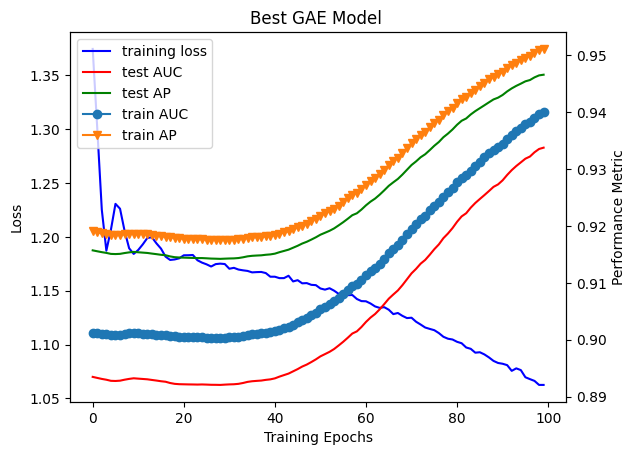

Best Threshold=0.604152


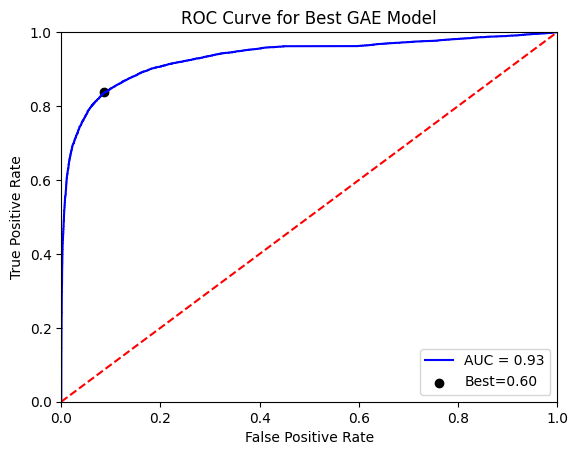

In [ ]:
plot_training_stats('Best GAE Model ', losses, test_auc, test_ap, train_aucs, train_aps)
plot_roc_curve('ROC Curve for Best GAE Model',gae_model, test_set)

#### VGAE model

In [ ]:
# define the Variational GCN Encoder
class VariationalGCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=False)
        self.conv_mu = GCNConv(hidden_size, out_channels, cached=False)
        self.conv_logstd = GCNConv(hidden_size, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv_mu(x_temp2, edge_index), self.conv_logstd(x_temp2, edge_index)


input_dim = num_features
hidden_dim = 500 #keep
output_dim = 1
learning_rate = 0.005 #keep
epochs = 100

vgae_model = VGAE(VariationalGCNEncoder(input_dim, hidden_dim, output_dim, dropout=0.5))
vgae_model = vgae_model.to(device)

##################
##################
##################
optimizer = torch.optim.Adam(vgae_model.parameters(), lr=learning_rate)
##################
##################
##################


In [ ]:
# Define the training function for VGAE
def vgae_train(train_data, vgae_model, optimizer):
    vgae_model.train()
    optimizer.zero_grad()
    z = vgae_model.encode(train_data.x.float(), train_data.edge_index)
    loss = vgae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
    loss += (1 / train_data.num_nodes) * vgae_model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def vgae_test(test_data, vgae_model):
    vgae_model.eval()
    z = vgae_model.encode(test_data.x.float(), test_data.edge_index)
    auc, ap = vgae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return auc, ap

losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

for epoch in range(1, epochs + 1):
    loss = vgae_train(train_set, vgae_model, optimizer)
    losses.append(loss)
    
    train_auc, train_ap = vgae_test(train_set, vgae_model)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    
    test_auc_value, test_ap_value = vgae_test(test_set, vgae_model)
    test_auc.append(test_auc_value)
    test_ap.append(test_ap_value)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Test AUC: {test_auc_value:.4f}, Test AP: {test_ap_value:.4f}')

Epoch: 001, Loss: 1.6423, Train AUC: 0.8970, Train AP: 0.9155, Test AUC: 0.8889, Test AP: 0.9114
Epoch: 002, Loss: 1.4930, Train AUC: 0.8948, Train AP: 0.9143, Test AUC: 0.8872, Test AP: 0.9101
Epoch: 003, Loss: 1.4401, Train AUC: 0.8961, Train AP: 0.9157, Test AUC: 0.8889, Test AP: 0.9117
Epoch: 004, Loss: 1.4184, Train AUC: 0.8994, Train AP: 0.9187, Test AUC: 0.8924, Test AP: 0.9148
Epoch: 005, Loss: 1.4014, Train AUC: 0.9020, Train AP: 0.9208, Test AUC: 0.8948, Test AP: 0.9169
Epoch: 006, Loss: 1.3804, Train AUC: 0.9035, Train AP: 0.9218, Test AUC: 0.8965, Test AP: 0.9183
Epoch: 007, Loss: 1.3584, Train AUC: 0.9041, Train AP: 0.9222, Test AUC: 0.8968, Test AP: 0.9187
Epoch: 008, Loss: 1.3202, Train AUC: 0.9043, Train AP: 0.9222, Test AUC: 0.8970, Test AP: 0.9188
Epoch: 009, Loss: 1.2906, Train AUC: 0.9043, Train AP: 0.9222, Test AUC: 0.8969, Test AP: 0.9187
Epoch: 010, Loss: 1.2617, Train AUC: 0.9044, Train AP: 0.9222, Test AUC: 0.8969, Test AP: 0.9187
Epoch: 011, Loss: 1.2597, Trai

In [ ]:
vgae_ranked_edge_list, vgae_ranked_dot_products = get_ranked_edges(test_set, vgae_model, num_dz_nodes=unique_dis)


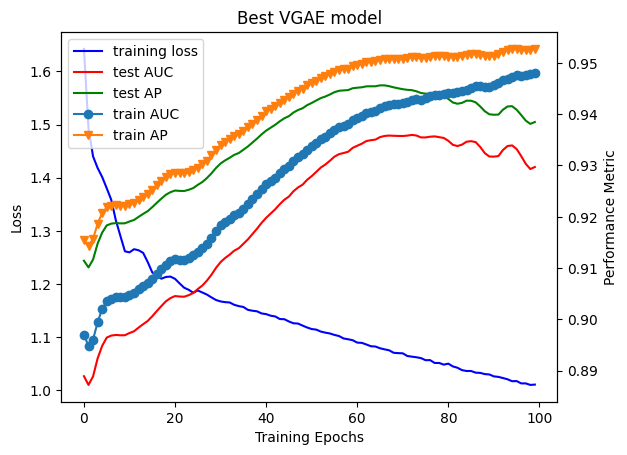

Best Threshold=0.603275


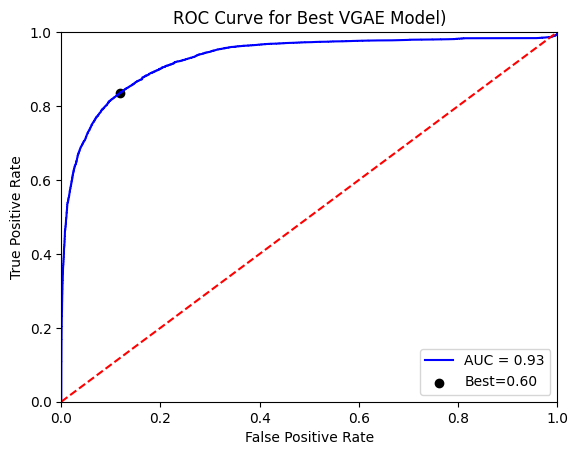

In [ ]:
plot_training_stats('Best VGAE model', losses, test_auc, test_ap, train_aucs, train_aps)
plot_roc_curve('ROC Curve for Best VGAE Model)',vgae_model, test_set)

In [ ]:
# view ranked edges
gea_ranked_edge_list, gea_ranked_dot_products = get_ranked_edges(test_set, gae_model, num_dz_nodes=unique_dis)
vgea_ranked_edge_list, vgea_ranked_dot_products = get_ranked_edges(test_set, gae_model, num_dz_nodes=unique_dis)

In [ ]:
disease_label_to_index = disease_mappings
index_to_gene_label = {v: k for k, v in gene_mappings.items()}

# get node index of TB
specific_disease = 'MONDO:0018076'
if specific_disease in disease_label_to_index:
    mondo_disease_index = disease_label_to_index[specific_disease]
    print(f"Index for {specific_disease}: {mondo_disease_index}")

    ranked_edge_list, ranked_dot_products = get_ranked_edges(test_set, gae_model, num_dz_nodes=len(disease_label_to_index))

    # filter ranked edges and dot products for TB in GAE moodel
    filtered_indices = np.where(ranked_edge_list[:, 0] == mondo_disease_index)
    filtered_ranked_edges = ranked_edge_list[filtered_indices]
    filtered_dot_products = ranked_dot_products[filtered_indices]

    # print prediction results
    print(f"Top {len(filtered_ranked_edges)} Ranked Edges for {specific_disease}:")
    for i in range(len(filtered_ranked_edges)):
        dz_index, gene_index = filtered_ranked_edges[i]
        gene_label = index_to_gene_label.get(gene_index - len(disease_label_to_index), f'Unknown Gene {gene_index}')
        dot_product = filtered_dot_products[i]
        print(f"Edge {i+1}: Disease Node {specific_disease} - Gene Node {gene_label} | Dot Product: {dot_product:.4f}")

    # make df and save it
    filtered_edges_df = pd.DataFrame({
        'Disease Node': [specific_disease] * len(filtered_ranked_edges),
        'Gene Node': [index_to_gene_label.get(gene_index - len(disease_label_to_index), f'Unknown Gene {gene_index}') for gene_index in filtered_ranked_edges[:, 1]],
        'Dot Product': filtered_dot_products
    })
    filtered_edges_df.to_csv(f'../data/filtered_ranked_edges_{specific_disease}.csv', index=False)

    print(f"Filtered ranked edges and dot products saved to '../data/processed/gae_tb_ranked_edges_{specific_disease}.csv'")
else:
    print(f"Disease {specific_disease} not found in the mapping.")

Index for MONDO:0018076: 26
Top 11939 Ranked Edges for MONDO:0018076:
Edge 1: Disease Node MONDO:0018076 - Gene Node 493 | Dot Product: 2.7114
Edge 2: Disease Node MONDO:0018076 - Gene Node 283 | Dot Product: 2.5622
Edge 3: Disease Node MONDO:0018076 - Gene Node 4830 | Dot Product: 2.5527
Edge 4: Disease Node MONDO:0018076 - Gene Node 10117 | Dot Product: 2.4875
Edge 5: Disease Node MONDO:0018076 - Gene Node 3202 | Dot Product: 2.4867
Edge 6: Disease Node MONDO:0018076 - Gene Node 886 | Dot Product: 2.4742
Edge 7: Disease Node MONDO:0018076 - Gene Node 2747 | Dot Product: 2.3242
Edge 8: Disease Node MONDO:0018076 - Gene Node 7706 | Dot Product: 2.2972
Edge 9: Disease Node MONDO:0018076 - Gene Node 142 | Dot Product: 2.2737
Edge 10: Disease Node MONDO:0018076 - Gene Node 890 | Dot Product: 2.2237
Edge 11: Disease Node MONDO:0018076 - Gene Node 1139 | Dot Product: 2.2194
Edge 12: Disease Node MONDO:0018076 - Gene Node 8811 | Dot Product: 2.2162
Edge 13: Disease Node MONDO:0018076 - Gene 

In [ ]:
# get predictions from training
disease_label_to_index = disease_mappings
index_to_gene_label = {v: k for k, v in gene_mappings.items()}

# get node index of TB
specific_disease = 'MONDO:0018076'
if specific_disease in disease_label_to_index:
    mondo_disease_index = disease_label_to_index[specific_disease]
    print(f"Index for {specific_disease}: {mondo_disease_index}")

    
    ranked_edge_list, ranked_dot_products = get_ranked_edges(test_set, vgae_model, num_dz_nodes=len(disease_label_to_index))

    # filter ranked edges and dot products for TB in VGAE model
    filtered_indices = np.where(ranked_edge_list[:, 0] == mondo_disease_index)
    filtered_ranked_edges = ranked_edge_list[filtered_indices]
    filtered_dot_products = ranked_dot_products[filtered_indices]

    # print prediction results
    print(f"Top {len(filtered_ranked_edges)} Ranked Edges for {specific_disease}:")
    for i in range(len(filtered_ranked_edges)):
        dz_index, gene_index = filtered_ranked_edges[i]
        gene_label = index_to_gene_label.get(gene_index - len(disease_label_to_index), f'Unknown Gene {gene_index}')
        dot_product = filtered_dot_products[i]
        print(f"Edge {i+1}: Disease Node {specific_disease} - Gene Node {gene_label} | Dot Product: {dot_product:.4f}")

    # make df and save it
    filtered_edges_df = pd.DataFrame({
        'Disease Node': [specific_disease] * len(filtered_ranked_edges),
        'Gene Node': [index_to_gene_label.get(gene_index - len(disease_label_to_index), f'Unknown Gene {gene_index}') for gene_index in filtered_ranked_edges[:, 1]],
        'Dot Product': filtered_dot_products
    })
    filtered_edges_df.to_csv(f'../data/filtered_ranked_edges_{specific_disease}.csv', index=False)

    print(f"Filtered ranked edges and dot products saved to '../data/processed/vgae_tb_ranked_edges_{specific_disease}.csv'")
else:
    print(f"Disease {specific_disease} not found in the mapping.")

Index for MONDO:0018076: 26
Top 11939 Ranked Edges for MONDO:0018076:
Edge 1: Disease Node MONDO:0018076 - Gene Node 493 | Dot Product: 3.3686
Edge 2: Disease Node MONDO:0018076 - Gene Node 10117 | Dot Product: 3.2862
Edge 3: Disease Node MONDO:0018076 - Gene Node 142 | Dot Product: 3.0700
Edge 4: Disease Node MONDO:0018076 - Gene Node 283 | Dot Product: 3.0583
Edge 5: Disease Node MONDO:0018076 - Gene Node 886 | Dot Product: 3.0578
Edge 6: Disease Node MONDO:0018076 - Gene Node 4830 | Dot Product: 3.0494
Edge 7: Disease Node MONDO:0018076 - Gene Node 3202 | Dot Product: 2.9751
Edge 8: Disease Node MONDO:0018076 - Gene Node 7706 | Dot Product: 2.9038
Edge 9: Disease Node MONDO:0018076 - Gene Node 8811 | Dot Product: 2.8634
Edge 10: Disease Node MONDO:0018076 - Gene Node 7494 | Dot Product: 2.8216
Edge 11: Disease Node MONDO:0018076 - Gene Node 890 | Dot Product: 2.7914
Edge 12: Disease Node MONDO:0018076 - Gene Node 7498 | Dot Product: 2.7820
Edge 13: Disease Node MONDO:0018076 - Gene 

#### Check SCA subnetwork to determine the signficance of the toplological properties and biological relevance

In [ ]:
# Number of random sets to generate
num_random_sets = 20

# Storage for random properties
random_topological_properties = []
random_num_interactions = []

# Initialize timer
t_start = time.time()

# Random sampling
for i in range(num_random_sets):
    print("Running iteration ", i+1)
    random_proteins = np.random.choice(connected_biogrid_graph.nodes(), size=len(tb_pos_disgenes), replace=False)
    random_proteins = random_proteins.tolist()
    random_sca = build_module(random_proteins, connected_biogrid_graph)
    random_subgraph = connected_biogrid_graph.subgraph(random_sca)
    
    # Calculate topological properties
    density = nx.density(random_subgraph)
    print(density)
    lcc_size = len(max(nx.connected_components(random_subgraph), key=len))
    print(lcc_size)
    num_interactions = random_subgraph.number_of_edges()
    print(num_interactions)
    
    # Store properties
    random_topological_properties.append((density, lcc_size))
    random_num_interactions.append(num_interactions)

# Calculate execution time
total_time = (time.time() - t_start) / 60
print(num_random_sets, " randomly SCA networks were done ... \n")
print("Execution time: ", round(total_time, 2), "minutes.")

# Calculate properties of the seed genes subgraph
seed_subgraph = connected_biogrid_graph.subgraph(get_module)
seed_density = nx.density(seed_subgraph)
seed_lcc_size = len(max(nx.connected_components(seed_subgraph), key=len))
seed_num_interactions = seed_subgraph.number_of_edges()

# Perform statistical analysis
random_densities = [prop[0] for prop in random_topological_properties]
random_lcc_sizes = [prop[1] for prop in random_topological_properties]

# Fit normal distribution and calculate p-values
density_mean, density_std = norm.fit(random_densities)
lcc_size_mean, lcc_size_std = norm.fit(random_lcc_sizes)

density_p_value = 2 * norm.cdf(-abs((seed_density - density_mean) / density_std))
lcc_size_p_value = 2 * norm.cdf(-abs((seed_lcc_size - lcc_size_mean) / lcc_size_std))

p_values = [density_p_value, lcc_size_p_value]
adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Print adjusted p-values
print("Adjusted p-values:", adjusted_p_values)


In [ ]:
# visualize results

# plot density plot for LCC size
plt.figure(figsize=(8, 6))
sns.kdeplot(random_lcc_sizes, fill=True, label="Random")
plt.axvline(x=seed_lcc_size, color='r', linestyle='--', label="Seed Genes")
plt.text(seed_lcc_size + 1, plt.gca().get_ylim()[1] * 0.8, f'Seed LCC Size: {seed_lcc_size}\nAdjusted p-value: {adjusted_p_values[1]:.10f}', color='r', ha='left')
plt.xlabel("LCC Size")
plt.ylabel("Probability Density")
plt.title(f"Density Plot for Largest Connected Component (LCC) Size (Number of iterations: {num_random_sets})")
plt.legend()
plt.savefig('../data/results/density_plot_lcc_size.png', dpi=600)
plt.show()

# plot density plot for number of interactions
plt.figure(figsize=(8, 6))
sns.kdeplot(random_num_interactions, fill=True, label="Random")
plt.axvline(x=seed_num_interactions, color='r', linestyle='--', label="Seed Genes")
plt.text(seed_num_interactions + 1, plt.gca().get_ylim()[1] * 0.8, f'Seed Interactions: {seed_num_interactions}\nAdjusted p-value: {adjusted_p_values[0]:.10f}', color='r', ha='left')
plt.xlabel("Number of Interactions")
plt.ylabel("Probability Density")
plt.title(f"Density Plot for Number of Interactions (Number of iterations: {num_random_sets})")
plt.legend()
plt.savefig('../data/results/density_plot_num_interactions.png', dpi=600)
plt.show()


NameError: name 'random_lcc_sizes' is not defined

<Figure size 800x600 with 0 Axes>